In [6]:
import logging
import logging.config

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from umap import UMAP


TRAINING_DATA_FILE = "Output/training_data.csv"
EMBEDDINGS_SEQ_FILE = "Output/embeddings_seq.csv"
EMBEDDINGS_MUT_FILE = "Output/embeddings_mut.csv"
MUTATION_SCORES_2_FILE = "Output/mutation_scores_2.csv"

SEQUENCE_MUTATION_PLOT = "Plots/sequence_mutation_pca.pdf"
SEQUENCE_EMBEDDINGS_PLOT = "Plots/sequence_embeddings_pca.pdf"

logging.config.fileConfig("logging.conf")


def plot_umap(
    df: pd.DataFrame,
    seq_lineage: pd.DataFrame,
    plot_name: str,
    min_label_counts: int = 50
):
    labels = seq_lineage.loc[df.index]["Lineage"]
    # labels = labels.str[0:5]
    label_counts = labels.value_counts()
    selected_labels = label_counts[
        (label_counts > min_label_counts) &
        (label_counts.index != "None")
    ].index

    X = StandardScaler().fit_transform(df)
    reducer = UMAP()
    embeddings = reducer.fit_transform(X)

    embeddings = pd.DataFrame(embeddings, columns=["umap1", "umap2"])
    embeddings["Label"] = labels.values
    embeddings = embeddings[embeddings["Label"].isin(selected_labels)]

    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        figsize=(6, 6)
    )

    for label, group in embeddings.groupby("Label"):
        ax.scatter(
            group["umap1"],
            group["umap2"],
            label=label,
            alpha=0.5
        )
    ax.legend()

    plt.savefig(plot_name)


[2022-01-09 12:29:45 AM]: Loading data..
[2022-01-09 12:29:53 AM]: Plot trained scores


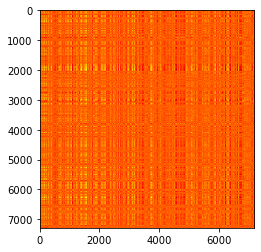

In [4]:
logging.info("Loading data..")

seq_mut = pd.read_csv(TRAINING_DATA_FILE)
seq_embbeddings = pd.read_csv(EMBEDDINGS_SEQ_FILE, index_col=0)
mut_embbedings = pd.read_csv(EMBEDDINGS_MUT_FILE, index_col=0)
mutation_scores = pd.read_csv(MUTATION_SCORES_2_FILE, index_col=0)

logging.info("Plot trained scores")

mutation_scores = ((mutation_scores > 0) * 1)
mutation_scores = mutation_scores.sort_index()

plt.imshow(np.array(mutation_scores), cmap="hot")
plt.savefig("Plots/mutation_scores_trained.pdf")


[2022-01-09 12:30:05 AM]: Plot original scores


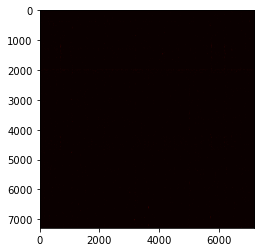

In [5]:
logging.info("Plot original scores")

seq_mutations = seq_mut.pivot_table(
    index="Accession",
    columns="Mutation",
    values="Value",
    fill_value=0
)
# seq_mutations = seq_mutations.drop_duplicates()
seq_mutations.sort_index()
plt.imshow(np.array(seq_mutations), cmap="hot")
plt.savefig("Plots/mutation_scores_original.pdf")


[2022-01-09 12:30:53 AM]: Plot sequence pca


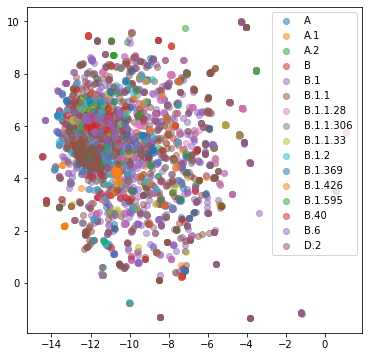

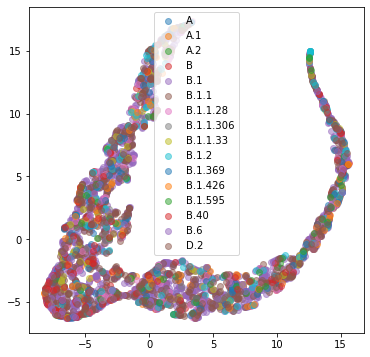

In [7]:
logging.info("Plot sequence pca")

seq_lineage = seq_mut[["Accession", "Lineage"]].drop_duplicates()
seq_lineage = seq_lineage.set_index("Accession")

plot_umap(seq_mutations, seq_lineage, SEQUENCE_MUTATION_PLOT)
plot_umap(seq_embbeddings, seq_lineage, SEQUENCE_EMBEDDINGS_PLOT)
# plot_pca(seq_embbeddings.dot(mut_embbedings.T),
#          seq_lineage, SEQUENCE_EMBEDDINGS_PLOT)
